In [16]:
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.sparse import csr_matrix

In [17]:
T = 0.5

theta = 0.25

Nt = 50
dt = T / (Nt - 1)
theta_steps = int(theta / dt)


sigma = 0.05

Nx = 31
Ny = 31
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)
points = grid_points.reshape((Nx, Ny, 2))
K = 32  # number of boundary points
Theta = np.linspace(0, 2 * np.pi, K, endpoint=False) 
alphas = np.stack((np.cos(Theta), np.sin(Theta)), axis=1)  # (K, 2) array

alpha = np.zeros((Nx, Ny, Nt-1, 2))

phi = np.zeros((len(x), len(y), Nt))
rho = np.zeros((len(x), len(y), Nt))


x_mask = (x >= 0.1) & (x <= 0.25)
y_mask = (y >= 0.1) & (y <= 0.25)

def l(rho):
    return 3*rho

def g(x, y):
    return np.sqrt((x-0.5)**2 + (y-0.5)**2)

def V(alpha):
    return alpha

In [18]:
def HJB(rho):
    for t in range(Nt-1, 0, -1):
        s1 = np.zeros((K, 2)) # phi(x+s1)
        s2 = np.zeros((K, 2)) # phi(x+s2)
        Vs = np.zeros((K,2))
        s1 = V(alphas)*dt + np.sqrt(2*dt*sigma)
        s2 = V(alphas)*dt - np.sqrt(2*dt*sigma)

        N = Nx * Ny
        grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)  # shape: (N, 2)

        grid_points_expanded = grid_points[:, None, :]

        s1_expanded = s1[None, :, :]                        

        all_points1 = grid_points_expanded + s1_expanded        # shape: (N, k, 2)
        all_points1 = all_points1.reshape(-1, 2)                # shape: (K*N, 2)


        s2_expanded = s2[None, :, :]
        all_points2 = grid_points_expanded + s2_expanded        # shape: (N, k, 2)
        all_points2 = all_points2.reshape(-1, 2)                # shape: (K*N, 2)

        def soft_penalty(p):
            p = np.array(p)
            clipped_p = np.clip(p, [x[0], y[0]], [x[-1], y[-1]])
            distance = np.linalg.norm(clipped_p - p)
            interp_val = v_interp_raw(clipped_p)
            return interp_val + 100*distance**2

        v_interp_raw = RegularGridInterpolator((x, y), phi[:,:,t],  bounds_error=False, fill_value=None)
        H = 1/2 * (soft_penalty(all_points1) + soft_penalty(all_points2))
        H = H.reshape(Nx, Ny, K)
        H_val = np.min(H, axis=2)  # shape: (Nx, Ny)
        alpha_index = np.argmin(H, axis=2)
        alpha[:, :, t-1, :] = alphas[alpha_index]

        phi[:, :, t-1] = H_val + l(rho[:, :, t]) * dt
    return phi, alpha

In [19]:
def FP(rho, alpha, time):
    Nt = int(time / dt)
    points = grid_points.reshape((Nx, Ny, 2))
    result = np.zeros((Nx, Ny, Nt))
    for k in range(Nt-1):
        result[:, :, k] = rho
        Y_k1 = (points + alpha[:, :, k, :] * dt + 1/2 * np.sqrt(2*sigma*dt))
        Y_k2 = (points + alpha[:, :, k, :] * dt - 1/2 * np.sqrt(2*sigma*dt))
        P = Nx * Ny
        points_flat = points.reshape(P, 2)
        Y1_flat = Y_k1.reshape(P, 2)
        Y2_flat = Y_k2.reshape(P, 2)

        # ∞-norm difference
        diff1 = np.abs(np.asarray(points_flat[:, None, :] - Y1_flat[None, :, :]))
        diff2 = np.abs(np.asarray(points_flat[:, None, :] - Y2_flat[None, :, :]))

        # Max-norm (∞-norm)
        dist1 = np.max(diff1, axis=2)
        dist2 = np.max(diff2, axis=2)
        
        # Apply β as box function
        B1 = (dist1 < 0.5 * dx).astype(float)
        B2 = (dist2 < 0.5 * dx).astype(float)
        
        colsum_B1 = np.sum(B1, axis=0)
        colsum_B2 = np.sum(B2, axis=0)
        colsum_total = colsum_B1 + colsum_B2
        # colsum_total[colsum_total == 0] = 1 
        B1 /= colsum_total
        B2 /= colsum_total
        B1 = csr_matrix(B1)
        B2 = csr_matrix(B2)
    
        # Weighted sum
        rho_new_flat = (B1 @ rho.reshape((Nx*Ny,)) + B2 @ rho.reshape((Nx*Ny,)))
        rho = rho_new_flat.reshape(Nx, Ny)
    result[:, :, -1] = rho
    return result

In [20]:
rho[np.ix_(x_mask, y_mask)] = 0.4   # Initial guess for rho
phi[:, :, -1] = g(X, Y)             # Terminal condition

for k in range(Nt - 1):  # main time loop
    print("Main timestep:", k)
    s_index = k
    t_start = s_index
    t_end = min(s_index + theta_steps, Nt - 1)

    # -----------  MFG: α^*(x, t) over [s, s+θ] --------
    rho_theta = copy.deepcopy(rho)
    for iter in range(20):
        phi, alpha = HJB(rho_theta)
        if s_index + theta_steps < Nt - 1:
            rho_theta_FP = FP(rho_theta[:, :, s_index], alpha, theta)
        else:
            rho_theta_FP = FP(rho_theta[:, :, s_index], alpha, T - s_index * dt)
        rho_theta[:, :, s_index:t_end] = rho_theta_FP[:, :, :]
        rho_theta[:, :, t_end:] = rho_theta_FP[:, :, -1][:, :, np.newaxis]

    #  α^*(x, s) compute main density
    alpha_s = alpha[:, :, s_index, :]  # shape (Nx, Ny, 2)

    # ----------- main density: update ρ(x, t_k+1) ----------
    Y_k1 = points + alpha_s * dt + 0.5 * np.sqrt(2 * sigma * dt)
    Y_k2 = points + alpha_s * dt - 0.5 * np.sqrt(2 * sigma * dt)

    P = Nx * Ny
    points_flat = points.reshape(P, 2)
    Y1_flat = Y_k1.reshape(P, 2)
    Y2_flat = Y_k2.reshape(P, 2)

    dist1 = np.max(np.abs(points_flat[:, None, :] - Y1_flat[None, :, :]), axis=2)
    dist2 = np.max(np.abs(points_flat[:, None, :] - Y2_flat[None, :, :]), axis=2)

    B1 = (dist1 < 0.5 * dx).astype(float)
    B2 = (dist2 < 0.5 * dx).astype(float)
    colsum_total = np.sum(B1, axis=0) + np.sum(B2, axis=0)
    colsum_total[colsum_total == 0] = 1.0  # 0
    B1 /= colsum_total
    B2 /= colsum_total

    rho_prev_flat = rho[:, :, k].reshape(P)
    rho_new_flat = B1 @ rho_prev_flat + B2 @ rho_prev_flat
    rho[:, :, k + 1] = rho_new_flat.reshape(Nx, Ny)


Main timestep: 0
Main timestep: 1
Main timestep: 2
Main timestep: 3
Main timestep: 4
Main timestep: 5
Main timestep: 6
Main timestep: 7
Main timestep: 8
Main timestep: 9
Main timestep: 10
Main timestep: 11
Main timestep: 12
Main timestep: 13
Main timestep: 14
Main timestep: 15
Main timestep: 16
Main timestep: 17
Main timestep: 18
Main timestep: 19
Main timestep: 20
Main timestep: 21
Main timestep: 22
Main timestep: 23
Main timestep: 24
Main timestep: 25
Main timestep: 26
Main timestep: 27
Main timestep: 28
Main timestep: 29
Main timestep: 30
Main timestep: 31
Main timestep: 32
Main timestep: 33
Main timestep: 34
Main timestep: 35
Main timestep: 36
Main timestep: 37
Main timestep: 38
Main timestep: 39
Main timestep: 40
Main timestep: 41
Main timestep: 42
Main timestep: 43
Main timestep: 44
Main timestep: 45
Main timestep: 46
Main timestep: 47
Main timestep: 48


Text(0.5, 1.0, '$\\rho(x,y,t=T)$')

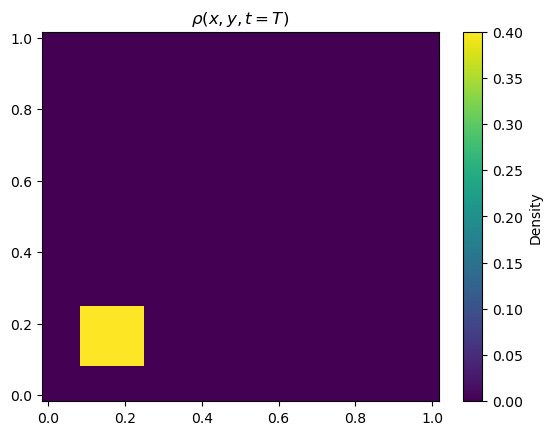

In [21]:
plt.pcolormesh(X, Y, rho[:, :, 0], shading='auto', cmap='viridis')
plt.colorbar(label='Density')
plt.title(r"$\rho(x,y,t=T)$")

Text(0.5, 1.0, '$\\rho(x,y,t=T)$')

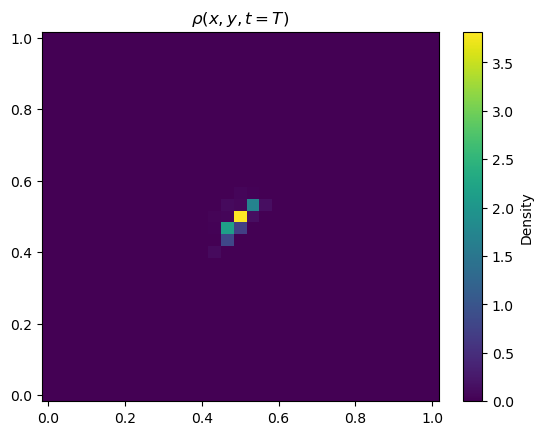

In [22]:
plt.pcolormesh(X, Y, rho[:, :, -1], shading='auto', cmap='viridis')
plt.colorbar(label='Density')
plt.title(r"$\rho(x,y,t=T)$")